Reconnaissance de chiffre
======================

Chargement des données
------------------------------------

In [80]:
import pandas as pd

train_df = pd.read_csv('datasets/digit/train.csv')
predict_df = pd.read_csv('datasets/digit/test.csv')

Préparation des données
------------------------------------

In [245]:
from sklearn.model_selection import train_test_split
import numpy as np
import cv2

generate_new_train_images = True
resize_images = False
if resize_images:
    width = 8
    height = 8
    blur_radius = (1, 1)
else:
    width = 28
    height = 28
    blur_radius = (3, 3)
length = width * height

def resize(images):
    resized_images = []
    for d in images.reshape((images.shape[0], 28, 28)):
        resized_images.append(cv2.resize(d, (width, height)))
    r = np.array(resized_images)
    return r.reshape((r.shape[0], length))

def blur(data):
    blur_data = []
    for d in data.reshape((data.shape[0], width, height)):
        blur_data.append(cv2.GaussianBlur(d, blur_radius, 0))
    bd = np.array(blur_data)
    return np.multiply(bd.reshape((data.shape[0], length)), 1.0 / 255.0)

def generate_train_images(X_in, y):
    X = X_in.reshape((X_in.shape[0], width, height))
    X_train_process = []
    y_train_process = []
    
    size = (width, height)
    center = (width / 2, height / 2)
    scale = 1.0
    
    transformations_M = [
        cv2.getRotationMatrix2D(center, 15, scale),
        cv2.getRotationMatrix2D(center, -15, scale),
        cv2.getRotationMatrix2D(center, 5, 0.8),
        cv2.getRotationMatrix2D(center, -5, 1.2),
 #       cv2.getRotationMatrix2D(center, 5, 1.1),
 #       cv2.getRotationMatrix2D(center, -5, 0.9)
    ]

    for i in range(len(X)):
        img = X[i]
        label = y[i]
        X_train_process.append(img)
        y_train_process.append(label)

        for M in transformations_M:
            X_train_process.append(cv2.warpAffine(img, M, size))
            y_train_process.append(label)

    X_out = np.array(X_train_process)
    return X_out.reshape((X_out.shape[0], length)), np.array(y_train_process)


train_labels = train_df['label'].values
if resize_images:
    train_images = resize(train_df.drop('label', axis=1).values.astype(np.float))
else:
    train_images = train_df.drop('label', axis=1).values.astype(np.float)
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, random_state=42)

if generate_new_train_images:
    X_train, y_train = generate_train_images(X_train, y_train)
X_train = blur(X_train)
X_test = blur(X_test)
if resize_images:
    predict_images = blur(resize(predict_df.values.astype(np.float)))
else:
    predict_images = blur(predict_df.values.astype(np.float))

Réduction du nombre de caractéristiques
-----------------------------------------------------------

In [250]:
from sklearn.decomposition import PCA

pca = PCA(n_components=300, random_state=42)
pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
predict_images_pca = pca.transform(predict_images)

Entrainement et prédictions avec une regression logistique
-------------------------------------------------------------------------------------

In [139]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=10000).fit(X_train, y_train)

print("Training set score : {:.5f}".format(lr.score(X_train, y_train)))
print("Test set score : {:.5f}".format(lr.score(X_test, y_test)))

predictions = lr.predict(predict_images)

Training set score : 0.89706
Test set score : 0.91238


Entrainement et prédictions avec un réseau de neurones
---------------------------------------------------------------------------------

In [251]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(solver='adam', max_iter=1000, activation='tanh',
                    hidden_layer_sizes=[300, 300], random_state=42)
mlp.fit(X_train_pca, y_train)

print("Training set score : {:.5f}".format(mlp.score(X_train_pca, y_train)))
print("Test set score : {:.5f}".format(mlp.score(X_test_pca, y_test)))

predictions = mlp.predict(predict_images_pca)

Training set score : 0.99994
Test set score : 0.98705


Génération du fichier de résultats
------------------------------------------------

In [252]:
out = { 'ImageId': [ i for i in range(1, len(predictions) + 1)], 'Label': predictions }
out_df = pd.DataFrame(out)
out_df.to_csv('/tmp/submission-digit.csv', encoding='utf-8', index=False)

Prediction sur le jeu de test pour visualiser les erreurs
------------------------------------------------------------------------------

In [262]:
test_predictions = mlp.predict(X_test_pca)
test_predictions_proba = mlp.predict_proba(X_test_pca)

test_errors = []
for i, p in enumerate(test_predictions):
    digit = y_test[i]
    if p != digit:
        test_errors.append({'prediction': p, 'digit': digit, 'idx': i, 'certitude': np.max(test_predictions_proba[i])})
        
print(len(test_errors))

136


Visualisation des erreurs sur le jeu de test
------------------------------------------------------------

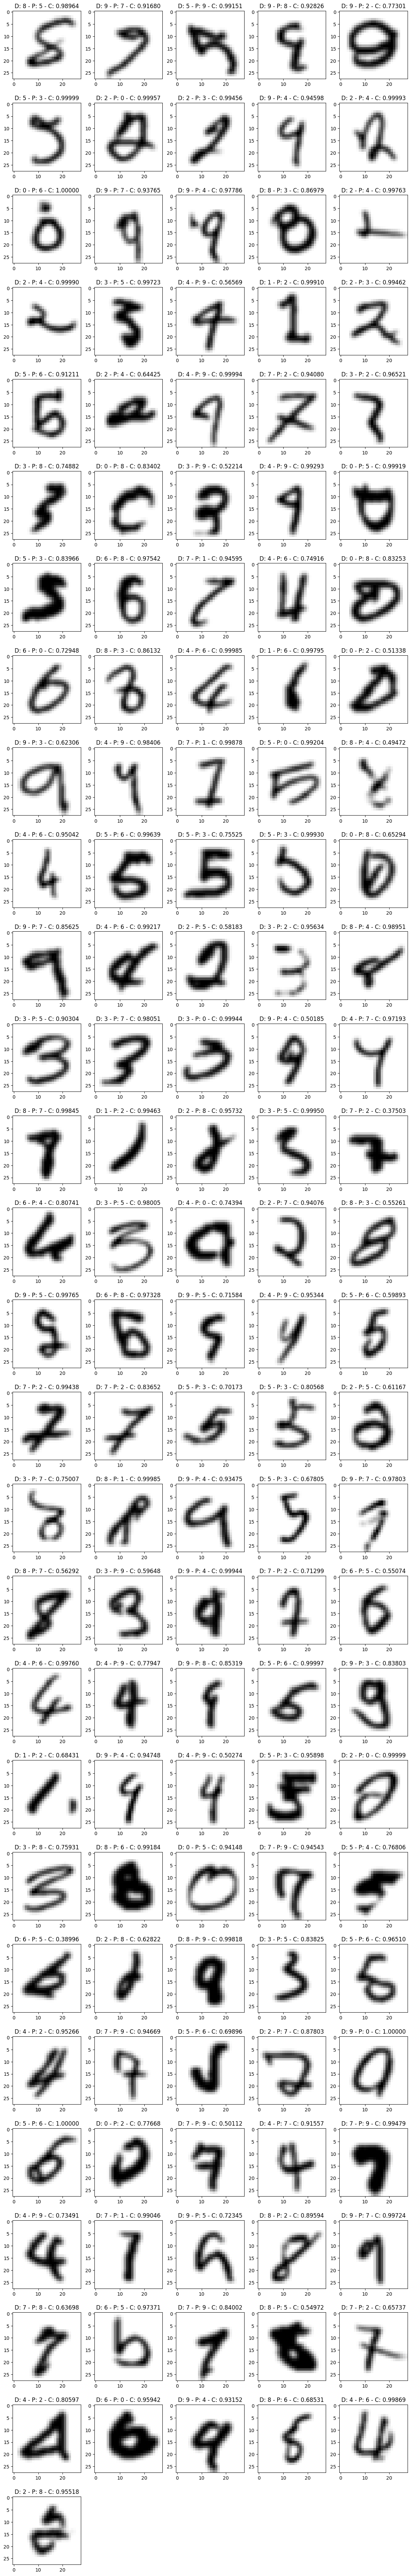

In [263]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 100), dpi=100)
columns = 5
rows = len(test_errors) / columns + 1
for i, err in enumerate(test_errors):
    plt.subplot(rows, columns, i + 1, title="D: %d - P: %d - C: %.5f" % (err['digit'], err['prediction'], err['certitude']))
    plt.imshow(X_test[err['idx']].reshape((width, height)), cmap='binary')